## Problem

Suppose we have a dataset containing statistics related to historical customer purchase behavior. 


Our dataset contains the following features:


*   `age`: Individual's age
*   `num_publications`: Individual's number of academic publications
*   `specialty`: Individual's clinical specialty
*   `marketing_dollars_spent`: Marketing dollars butterfly spent directed towards this individual


And the following outcome variable:
*   `purchased`: Whether the person ultimately purchased a device


Our goal is two-fold:
    1. Analyze the causal relationship between the features and outcomes.
    2. Build an accurate model for forecasting whether a future customer will purchase a device.

## Approach

Causal relationships are often times easily gleaned from the output a model built to either explain or predict an outcome (target variable) from a set of feature variables.  In order to best inform the choice of model to be built for explanatory or predictive purposes and to make sure that the feature set is complete and well formed (i.e., normalized, transformed, etc.), the data needs to be explored and understood.  This involves looking at descriptive statistics for feature and target variables, visualizing the distributions of feature and target values, and determining the correlation amongst features and between features and the target variable.  The results of this exploration will then dictate the steps needed for data preparation and model selection.

In this case, the predictive model will be a binary classifier.  This type of model will output a probability that a customer will purchase a device given their unique set of feature values.  Logisitic regression, gaussian naive bayes, and decision tree ensembles are model types that can be used for binary classification.  The model type will be driven by the results of the data exploration phase.  The accuracy of the model will be measured by the area under the receiver operator characteristic curve (AUC).  The AUC metric tells us how much better a model is at predicting the target variable than random guessing.  In addition, AUC is a standardized metric that allows for comparison across different models and model types. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import preprocessing, metrics
from sklearn.linear_model import LogisticRegression
import os
import sys
import re
import math
import pdb
import warnings

In [2]:
df = pd.read_csv('customers.csv')
df.drop('Unnamed: 0', inplace=True, axis=1)

## Data Exploration and Analysis

In [3]:
len(df)

10000

In [4]:
df.head()

,age,num_publications,specialty,marketing_dollars_spent,purchased
0,47,4,other,26,False
1,27,6,other,27,False
2,39,7,internal medicine,3,True
3,35,11,other,29,False
4,54,8,obgyn,1,False


In [5]:
df.dtypes

age                         int64
num_publications            int64
specialty                  object
marketing_dollars_spent     int64
purchased                    bool
dtype: object

The dataset contains 10K records with 4 feature columns and 1 target column.  The feature set contains 3 integer columns (age, num_publications, and marketing_dollars_spent) and 1 categorical column (specialty).  The target variable, purchased, is a column of booleans.

In [6]:
num_columns = ['age', 'num_publications', 'marketing_dollars_spent']
cat_columns = ['specialty']
target_column = 'purchased'

In [7]:
df.describe()

,age,num_publications,marketing_dollars_spent
count,10000.000000,10000.000000,10000.000000
mean,42.012400,7.038400,14.527400
std,10.099101,2.634316,8.686495
min,25.000000,0.000000,0.000000
25%,33.000000,5.000000,7.000000
50%,42.000000,7.000000,14.000000
75%,51.000000,9.000000,22.000000
max,59.000000,22.000000,29.000000


Looking at the descriptive statistics for the numeric feature columns, we can see that there is no missing data.  In addition, the min, max and standard deviation of feature values indicates that there are no outliers present.  Finally, the fact that there is a relative uniform spread across quartile values suggests that the distributions of the feature values are not highly skewed.  Therefore, it is most likely that the numeric features do not need to be transformed or standarized before being used for model building.

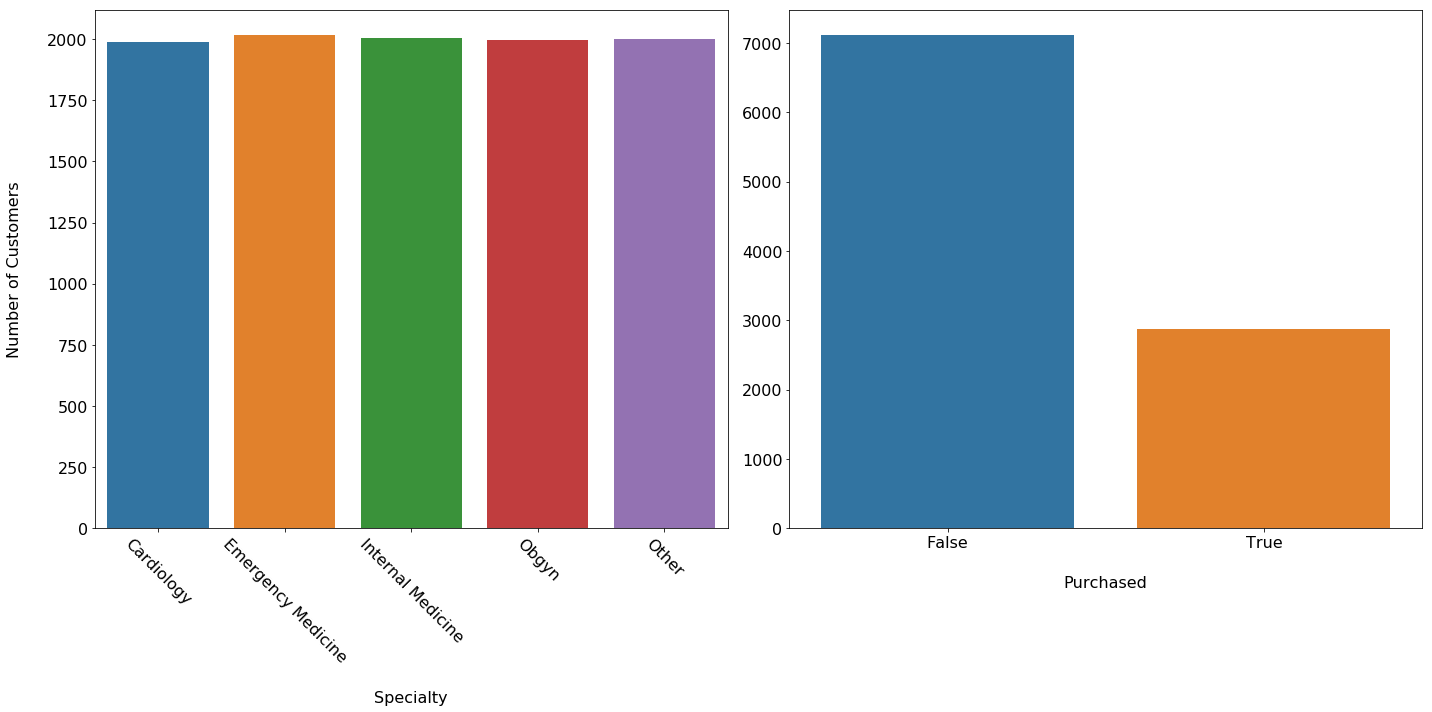

In [8]:
ncols = 2
nrows = 1

fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(20, 10)

plt_row = 0
plt_col = 0

for col in cat_columns + [target_column]:
    my_ax = ax[plt_col]

    df_temp = df.groupby([col], as_index=False).agg({'age': 'count'})
    
    sns.barplot(x=col, y='age', data=df_temp, ax=my_ax)
    
    my_ax.tick_params(labelsize=16, axis='both')
    my_ax.set_xlabel(col.replace('_', ' ').title(), labelpad=25, fontdict={'fontsize':16})
    
    if plt_col == 0:
        my_ax.set_ylabel('Number of Customers', labelpad=25, fontdict={'fontsize': 16})
        my_ax.set_xticklabels(sorted([x.title() for x in df_temp[col].unique()]))
        my_ax.tick_params(rotation=-45, axis='x')
    else:
        my_ax.set_ylabel('')
          
    plt_col += 1

    if plt_col == ncols:
        plt_col = 0
        plt_row += 1
        

plt.tight_layout()
plt.show()

There are five unique values for the categorical feature specialty.  The dataset is more or less uniformly spread across each of the five values.  Therefore, it is most likely this feature does not need to be transformed or standardized before being used for modeling building.

With respect to the target variable, 30% of customers have purchased the product while 70% have not.  This introduces an imbalance to the dataset although not large enough to force adjustments to the dataset or consider more complex modeling techniques at the onset of model building.

The next step is to visualize the distributions of the numeric features to confirm what was seen with the descriptive statistics above.  This is done by drawing histograms for each feature.

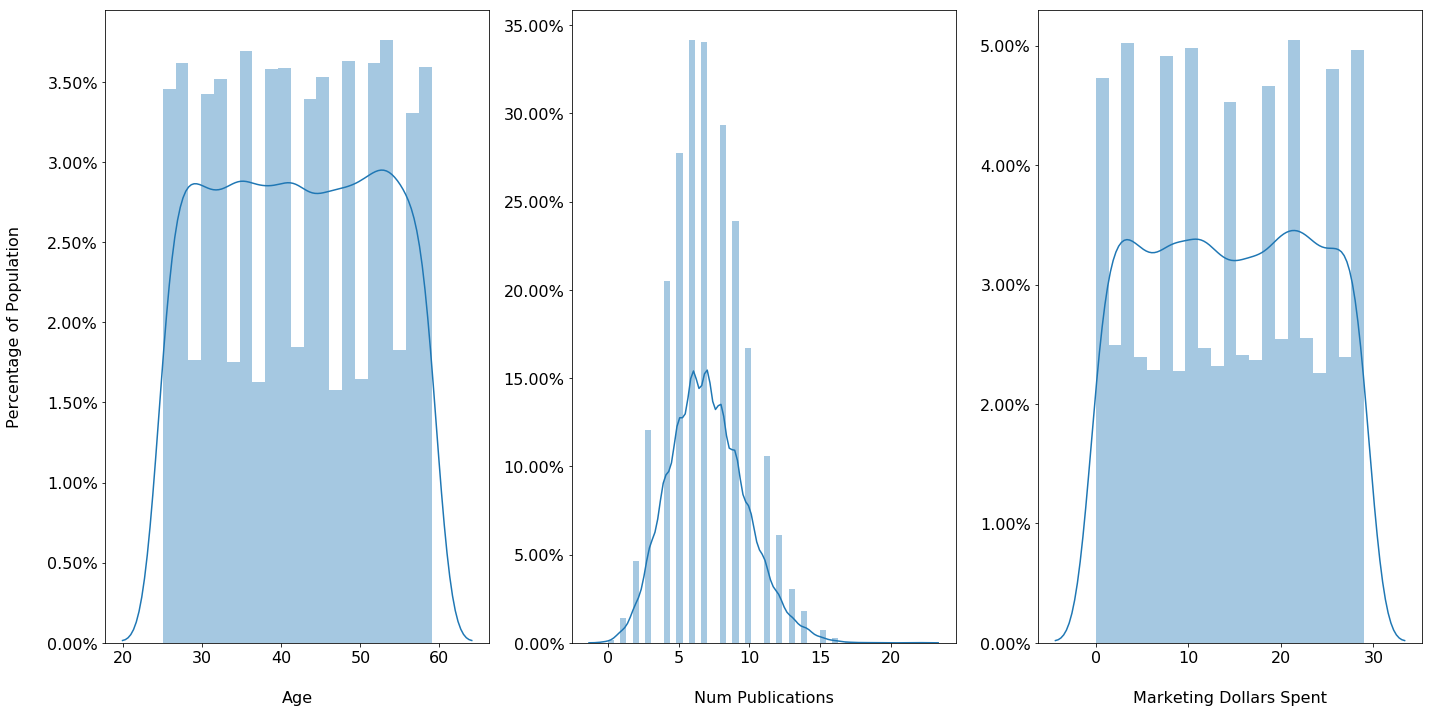

In [9]:
ncols = 3
nrows = 1

fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(20, 10)

plt_row = 0
plt_col = 0

for col in num_columns:
    my_ax = ax[plt_col]

    sns.distplot(df[col], ax=my_ax)
    
    my_ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: '{0:.2f}%'.format(x*100)))
    my_ax.tick_params(labelsize=16, axis='both')
    my_ax.set_xlabel(col.replace('_', ' ').title(), labelpad=25, fontdict={'fontsize':16})
    
    if plt_col == 0:
        my_ax.set_ylabel('Percentage of Population', labelpad=25, fontdict={'fontsize': 16})
          
    plt_col += 1

    if plt_col == ncols:
        plt_col = 0
        plt_row += 1
        

plt.tight_layout()
plt.show()

No surprises here. Age and Marketing Dollars Spent are uniformly distributed.  Num Publications exhibits a truncated normal distribution. 

Increasing the level of granularity, we can take a look at how each numeric feature varies over each of specialty value.  Again, this serves to inform data preparation and model selection.  It also serves to give an idea of what relationships we expect to see from the output of the model.  If the model says something different than what is indicated by the data, we must look closer at both the data, the model parameters and the model choice.

In [10]:
df.groupby(['specialty']).describe().T

specialty                       cardiology  emergency medicine  \
age                     count  1986.000000         2018.000000   
                        mean     42.300604           42.221011   
                        std      10.121816           10.044458   
                        min      25.000000           25.000000   
                        25%      34.000000           34.000000   
                        50%      43.000000           42.000000   
                        75%      51.000000           51.000000   
                        max      59.000000           59.000000   
marketing_dollars_spent count  1986.000000         2018.000000   
                        mean     14.612286           14.873637   
                        std       8.720325            8.650281   
                        min       0.000000            0.000000   
                        25%       7.000000            8.000000   
                        50%      15.000000           15.000000   
                        75%      22.000000           22.000000   
                        max      29.000000           29.000000   
num_publications        count  1986.000000         2018.000000   
                        mean      7.054381            7.021804   
                        std       2.695096            2.631475   
                        min       0.000000            0.000000   
                        25%       5.000000            5.000000   
                        50%       7.000000            7.000000   
                        75%       9.000000            9.000000   
                        max      22.000000           16.000000   

specialty                      internal medicine        obgyn        other  
age                     count        2004.000000  1994.000000  1998.000000  
                        mean           42.066367    41.731194    41.741742  
                        std            10.209981    10.120645     9.993807  
                        min            25.000000    25.000000    25.000000  
                        25%            33.000000    33.000000    33.000000  
                        50%            42.000000    41.000000    42.000000  
                        75%            51.000000    51.000000    50.000000  
                        max            59.000000    59.000000    59.000000  
marketing_dollars_spent count        2004.000000  1994.000000  1998.000000  
                        mean           14.280439    14.416249    14.451952  
                        std             8.686427     8.730063     8.642423  
                        min             0.000000     0.000000     0.000000  
                        25%             7.000000     7.000000     7.000000  
                        50%            14.000000    14.000000    15.000000  
                        75%            22.000000    22.000000    22.000000  
                        max            29.000000    29.000000    29.000000  
num_publications        count        2004.000000  1994.000000  1998.000000  
                        mean            7.089820     7.040622     6.985485  
                        std             2.573709     2.662643     2.609119  
                        min             0.000000     1.000000     1.000000  
                        25%             5.000000     5.000000     5.000000  
                        50%             7.000000     7.000000     7.000000  
                        75%             9.000000     9.000000     9.000000  
                        max            16.000000    18.000000    19.000000

Similar to what was seen at lower granularity, the numeric data is well behaved within each speciality and consistent across each specialty.

The next step is to calculate the correlations amongst features and between features and the target variable.  We use the Pearson correlation coefficient for correlation.  This may not be the most appropriate for correlation between a discrete feature variables and the categorical target variable.  We may want to calculate mutual information or use chi-squared instead if necessary.

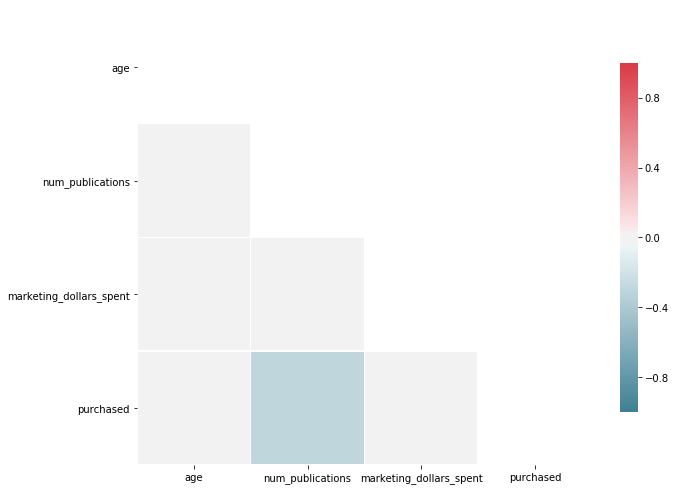

In [11]:
corr = df[num_columns + [target_column]].corr(method='pearson')

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 10)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.tight_layout()
plt.show()

There is no correlation amongst the numeric features so we most likely do not have to worry about multicollinearity when using logistic regression models.  There is a negative correlation between the number of publications and whether the product is purchased. This means that, in general, customers with more publications have less purchases. 

The last piece of information that will be looked at to help inform expectations of causality is to calculate the conversion rate (i.e., the percentage of customers that have purchased) by specialty.  

In [12]:
df_conversion_rates = df.groupby(['specialty']).agg({'purchased': 'sum', 'age': 'count'})
df_conversion_rates = df_conversion_rates.rename(columns={'age': 'number_of_customers'})
df_conversion_rates['conversion_rate'] = df_conversion_rates.purchased / df_conversion_rates.number_of_customers
df_conversion_rates.sort_values(['conversion_rate'], ascending=False)

,purchased,number_of_customers,conversion_rate
specialty,,,
internal medicine,1723.0,2004,0.859780
emergency medicine,643.0,2018,0.318632
other,241.0,1998,0.120621
cardiology,172.0,1986,0.086606
obgyn,102.0,1994,0.051153


Based on the sample data, customers in internal medicine have by far the highest conversion rate at 86% with emergency medicine professionals coming in next with 32%.  Obgyn customers have the lowest conversion rate at 5%.

## Model Selection and Building

Given the following observations regarding the data, it makes sense to start model building with logistic regression.  

*  The numeric features are either uniformly or normally distributed with no outliers.
*  There is only a moderate imbalance in the dataset with respect to the target variable.
*  There is no indication of multicollinearity for the feature set.
*  There is correlation between the number of publications and purchasing as well as varying purchase behavior across specialties.

Logistic regression is a model whose prediction is the log odds for purchase given a unique set of feature values.  These log odds can then be transformed into probabilities of purchase.  

Logistic regression can only handle numeric features so we need to one hot encode the categorical feature specialty.  One hot encoding creates new binary columns (0 or 1) separating each possible categorical value into a column.  We have to drop one of the binary columns to avoid introducing multicollinearity.  In this case, we will drop the encoding column for specialty other.  As a result, the intercept of the model will represent the coefficient for that binary column.

In [13]:
col_dummies = pd.get_dummies(df[cat_columns]) #one hot encoding
col_dummies.drop(['specialty_other'], inplace=True, axis=1) #drop one column
df_model = df.merge(col_dummies, how='inner', right_index=True, left_index=True) #merge one hot with numerical features
df_model.drop(['specialty'], inplace=True, axis=1) #drop original categorical column 
df_model.head()

,age,num_publications,marketing_dollars_spent,purchased,specialty_cardiology,specialty_emergency medicine,specialty_internal medicine,specialty_obgyn
0,47,4,26,False,0,0,0,0
1,27,6,27,False,0,0,0,0
2,39,7,3,True,0,0,1,0
3,35,11,29,False,0,0,0,0
4,54,8,1,False,0,0,0,1


Now that the data is well formed, we fit a logistic regression and look at the regression coefficents.

In [14]:
feature_columns = list(set(df_model.columns)-set(['purchased']))
log_reg = LogisticRegression()
log_reg.fit(X=df_model[feature_columns], y=df_model[target_column])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
roc_auc_score = metrics.roc_auc_score(df_model[target_column], log_reg.predict(df_model[feature_columns]))
print('AUC: {0:0.6f}'.format(roc_auc_score))

AUC: 0.893579


In [16]:
model_coefs = list(zip(['specialty_other'] + feature_columns, [log_reg.intercept_[0]] + list(log_reg.coef_[0])))
pd.DataFrame(model_coefs, columns=['feature', 'coefficient']).sort_values(['coefficient'], ascending=False)

,feature,coefficient
6,specialty_internal medicine,5.397193
5,specialty_emergency medicine,1.621306
0,specialty_other,1.538391
1,marketing_dollars_spent,0.006008
4,age,0.000945
2,specialty_cardiology,-0.458155
7,num_publications,-0.634882
3,specialty_obgyn,-1.089557


## Model Evaluation

The model that was built corroborates what was seen during the data exploration phase.
*  Very small coefficients for age and marketing_dollars_spend confirming very little correlation with purchasing
*  Negative coefficient for num_publications confirming negative correlation with purchasing
*  The ranking of coefficients for specialties are similar to rankings by conversion rate

The logistic regression model has an AUC of 0.89 which means that it is much better than a random guess and could potentially be used going forward to predict customer purchasing behavior.  In order for this to happen though, model performance (AUC) needs to be confirmed through cross validation.  Note that it might be possible to improve AUC by using decision tree ensembles or gaussian naive bayes models.  Finally, before productionizing a model, we would want to look at the confusion matrix for different threshold probabilities if false positive rates and/or false negative rates are a concern from a business perspective.